# For LUT and master trace generation

## To reproduce the Look Up Table (LUT) for the combs and fibre positions

In [ ]:
from llamas_pyjamas.Utils import dump_LUT
from llamas_pyjamas.TraceLlamas import TraceLlamas
from astropy.io import fits

channel = 'green' #re-run this for each color

calibration_fits_file = 'path/to/raw/calibration/file'

hdu = fits.open(calibration_fits_file)
trace = TraceLlamas(calibration_fits_file, find_LUT=True)

dump_LUT(channel, hdu, trace)

## To flip fibre position ordering in the LUT based on the colour and side

In [ ]:
from llamas_pyjamas.Utils import flip_positions

flipped = {"greenA":True, "greenB":False, "blueA": False, "blueB":True, "redA":True, "redB":False}

flip_positions()

# To produce a master bias file

In [ ]:
from llamas_pyjamas.Bias.llamasBias import BiasLlamas

bias_list =['file1.fits', 'file2.fits', 'file3.fits']
bias = BiasLlamas(bias_list)
bias.master_bias() #this will produce a file in mastercalib called combined_bias.fits



---
### Testing

In [1]:
# ============================================================================
# FUNCTION 1: Extract single color from FITS file
# ============================================================================

def extract_color_from_fits(input_fits, color, output_dir, output_filename=None):
    """
    Extract a single color (red, green, or blue) from a raw science frame.
    
    Creates a FITS file with the primary header and only the extensions
    for the specified color.
    
    Parameters:
        input_fits: Path to input FITS file
        color: Color to extract ('red', 'green', or 'blue')
        output_dir: Directory for output file
        output_filename: Output filename (default: input_basename_{color}.fits)
    
    Returns:
        str: Path to output FITS file
    """
    import os
    from astropy.io import fits
    
    RED_IDXS = [1, 4, 7, 10, 13, 16, 19, 22]
    GREEN_IDXS = [2, 5, 8, 11, 14, 17, 20, 23]
    BLUE_IDXS = [3, 6, 9, 12, 15, 18, 21, 24]
    
    # Validate color input
    color = color.lower()
    if color not in ['red', 'green', 'blue']:
        raise ValueError(f"Color must be 'red', 'green', or 'blue', got '{color}'")
    
    # Select appropriate indices
    if color == 'red':
        idxs = RED_IDXS
    elif color == 'green':
        idxs = GREEN_IDXS
    else:  # blue
        idxs = BLUE_IDXS
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Determine output filename
    if output_filename is None:
        base = os.path.splitext(os.path.basename(input_fits))[0]
        output_filename = f"{base}_{color}.fits"
    
    output_fits = os.path.join(output_dir, output_filename)
    
    print(f"Extracting {color} extensions from: {input_fits}")
    
    # Open input and create output
    with fits.open(input_fits) as hdul:
        print(f"Input has {len(hdul)} HDUs (primary + {len(hdul)-1} extensions)")
        
        # Start with primary header
        output_hdus = fits.HDUList([hdul[0].copy()])
        
        # Add only the specified color extensions
        for idx in idxs:
            if idx < len(hdul):
                output_hdus.append(hdul[idx].copy())
                extname = hdul[idx].header.get('EXTNAME', f'EXT_{idx}')
                print(f"  Added extension {idx}: {extname}")
            else:
                print(f"  Warning: Extension {idx} not found in input file")
        
        # Write output
        print(f"Writing {color} file with {len(output_hdus)-1} extensions: {output_fits}")
        output_hdus.writeto(output_fits, overwrite=True)
    
    print(f"{color.capitalize()} extraction complete!")
    return output_fits

# ============================================================================
# FUNCTION 2: Recombine color-separated FITS files
# ============================================================================

def recombine_fits_by_color(red_fits, green_fits, blue_fits, output_fits):
    """
    Recombine separate red, green, and blue FITS files back into original ordering.
    
    Output ordering: RED1A, GREEN1A, BLUE1A, RED1B, GREEN1B, BLUE1B, ..., BLUE4B
    
    Parameters:
        red_fits: Path to red FITS file (8 extensions)
        green_fits: Path to green FITS file (8 extensions)
        blue_fits: Path to blue FITS file (8 extensions)
        output_fits: Path for output combined file
    
    Returns:
        str: Path to output file
    """
    import os
    from astropy.io import fits
    
    RED_IDXS = [1, 4, 7, 10, 13, 16, 19, 22]
    GREEN_IDXS = [2, 5, 8, 11, 14, 17, 20, 23]
    BLUE_IDXS = [3, 6, 9, 12, 15, 18, 21, 24]
    
    print(f"Recombining color-separated FITS files into: {output_fits}")
    print(f"  Red: {red_fits}")
    print(f"  Green: {green_fits}")
    print(f"  Blue: {blue_fits}")
    
    with fits.open(red_fits) as red_hdul, \
         fits.open(green_fits) as green_hdul, \
         fits.open(blue_fits) as blue_hdul:
        
        print(f"Red: {len(red_hdul)-1} extensions")
        print(f"Green: {len(green_hdul)-1} extensions")
        print(f"Blue: {len(blue_hdul)-1} extensions")
        
        # Create mapping from target extension index to source HDU
        red_map = {RED_IDXS[i]: red_hdul[i+1] for i in range(len(red_hdul)-1)}
        green_map = {GREEN_IDXS[i]: green_hdul[i+1] for i in range(len(green_hdul)-1)}
        blue_map = {BLUE_IDXS[i]: blue_hdul[i+1] for i in range(len(blue_hdul)-1)}
        
        # Start with primary header
        combined_hdus = fits.HDUList([red_hdul[0].copy()])
        
        # Add extensions in order 1-24
        for ext_idx in range(1, 25):
            if ext_idx in red_map:
                combined_hdus.append(red_map[ext_idx].copy())
            elif ext_idx in green_map:
                combined_hdus.append(green_map[ext_idx].copy())
            elif ext_idx in blue_map:
                combined_hdus.append(blue_map[ext_idx].copy())
            else:
                print(f"Warning: Extension {ext_idx} not found!")
        
        print(f"Writing combined file with {len(combined_hdus)-1} extensions")
        combined_hdus.writeto(output_fits, overwrite=True)
    
    print("Recombination complete!")
    return output_fits

In [2]:
red_flat_file = '/Users/slh/Library/CloudStorage/Box-Box/slhughes/Llamas_Commissioning_Data/2025-03-06/LLAMAS_2025-03-06T20_07_54.653_mef.fits'
green_flat_file = '/Users/slh/Library/CloudStorage/Box-Box/slhughes/Llamas_Commissioning_Data/2025-03-06/LLAMAS_2025-03-06T20_12_57.828_mef.fits'
blue_flat_file = '/Users/slh/Library/CloudStorage/Box-Box/slhughes/Llamas_Commissioning_Data/2025-03-06/LLAMAS_2025-03-06T20_21_47.639_mef.fits'

In [4]:
output_dir = '/Users/slh/Documents/Projects/Magellan_dev/LLAMAS/testing/flat_fielding_tests/_tmp'

extract_color_from_fits(red_flat_file, 'red', output_dir=output_dir)
extract_color_from_fits(green_flat_file, 'green', output_dir=output_dir)
extract_color_from_fits(blue_flat_file, 'blue', output_dir=output_dir)

Extracting red extensions from: /Users/slh/Library/CloudStorage/Box-Box/slhughes/Llamas_Commissioning_Data/2025-03-06/LLAMAS_2025-03-06T20_07_54.653_mef.fits
Input has 25 HDUs (primary + 24 extensions)
  Added extension 1: EXT_1
  Added extension 4: EXT_4
  Added extension 7: EXT_7
  Added extension 10: EXT_10
  Added extension 13: EXT_13
  Added extension 16: EXT_16
  Added extension 19: EXT_19
  Added extension 22: EXT_22
Writing red file with 8 extensions: /Users/slh/Documents/Projects/Magellan_dev/LLAMAS/testing/flat_fielding_tests/_tmp/LLAMAS_2025-03-06T20_07_54.653_mef_red.fits
Red extraction complete!
Extracting green extensions from: /Users/slh/Library/CloudStorage/Box-Box/slhughes/Llamas_Commissioning_Data/2025-03-06/LLAMAS_2025-03-06T20_12_57.828_mef.fits
Input has 25 HDUs (primary + 24 extensions)
  Added extension 2: EXT_2
  Added extension 5: EXT_5
  Added extension 8: EXT_8
  Added extension 11: EXT_11
  Added extension 14: EXT_14
  Added extension 17: EXT_17
  Added exte

'/Users/slh/Documents/Projects/Magellan_dev/LLAMAS/testing/flat_fielding_tests/_tmp/LLAMAS_2025-03-06T20_21_47.639_mef_blue.fits'

In [ ]:
red_test = '/Users/slh/Documents/Projects/Magellan_dev/LLAMAS/testing/flat_fielding_tests/_tmp/LLAMAS_2025-03-06T20_07_54.653_mef_red.fits'

import matplotlib.pyplot as plt
from astropy.io import fits

hdu = fits.open(red_test)
print(len(hdu)) 
for i in range(1, len(hdu)):
    print(hdu[i].header['COLOR'])
    print(hdu[i].header['BENCH'])
    print(hdu[i].header['SIDE'])
    # print(hdu[i].header.cards)

plot = False
if plot:
    plt.figure(figsize=(10, 6))
    plt.imshow(hdu[1].data, cmap='gray', origin='lower')
    plt.colorbar(label='Pixel Value')
    plt.title('Red Extension 1A Data')
    plt.xlabel('X Pixel')
    plt.ylabel('Y Pixel')
    plt.show()

In [17]:
green_test = '/Users/slh/Documents/Projects/Magellan_dev/LLAMAS/testing/flat_fielding_tests/_tmp/LLAMAS_2025-03-06T20_12_57.828_mef_green.fits'
blue_test = '/Users/slh/Documents/Projects/Magellan_dev/LLAMAS/testing/flat_fielding_tests/_tmp/LLAMAS_2025-03-06T20_21_47.639_mef_blue.fits'

output_test = '/Users/slh/Documents/Projects/Magellan_dev/LLAMAS/testing/flat_fielding_tests/_tmp/combined_flat_images.fits'

recombine_fits_by_color(
    red_fits=red_test,
    green_fits=green_test,
    blue_fits=blue_test,
    output_fits=output_test
)

Recombining color-separated FITS files into: /Users/slh/Documents/Projects/Magellan_dev/LLAMAS/testing/flat_fielding_tests/_tmp/combined_flat_images.fits
  Red: /Users/slh/Documents/Projects/Magellan_dev/LLAMAS/testing/flat_fielding_tests/_tmp/LLAMAS_2025-03-06T20_07_54.653_mef_red.fits
  Green: /Users/slh/Documents/Projects/Magellan_dev/LLAMAS/testing/flat_fielding_tests/_tmp/LLAMAS_2025-03-06T20_12_57.828_mef_green.fits
  Blue: /Users/slh/Documents/Projects/Magellan_dev/LLAMAS/testing/flat_fielding_tests/_tmp/LLAMAS_2025-03-06T20_21_47.639_mef_blue.fits
Red: 8 extensions
Green: 8 extensions
Blue: 8 extensions
Writing combined file with 24 extensions
Recombination complete!


'/Users/slh/Documents/Projects/Magellan_dev/LLAMAS/testing/flat_fielding_tests/_tmp/combined_flat_images.fits'

In [18]:
hdu = fits.open(output_test)
print(len(hdu)) 
for i in range(1, len(hdu)):
    col = hdu[i].header['COLOR']
    bench = hdu[i].header['BENCH']
    side = hdu[i].header['SIDE']
    print(f"Extension {i}: COLOR={col}, BENCH={bench}, SIDE={side}")
    # print(hdu[i].header.cards)

25
Extension 1: COLOR=red, BENCH=1, SIDE=A
Extension 2: COLOR=green, BENCH=1, SIDE=A
Extension 3: COLOR=blue, BENCH=1, SIDE=A
Extension 4: COLOR=red, BENCH=1, SIDE=B
Extension 5: COLOR=green, BENCH=1, SIDE=B
Extension 6: COLOR=blue, BENCH=1, SIDE=B
Extension 7: COLOR=red, BENCH=2, SIDE=A
Extension 8: COLOR=green, BENCH=2, SIDE=A
Extension 9: COLOR=blue, BENCH=2, SIDE=A
Extension 10: COLOR=red, BENCH=2, SIDE=B
Extension 11: COLOR=green, BENCH=2, SIDE=B
Extension 12: COLOR=blue, BENCH=2, SIDE=B
Extension 13: COLOR=red, BENCH=3, SIDE=A
Extension 14: COLOR=green, BENCH=3, SIDE=A
Extension 15: COLOR=blue, BENCH=3, SIDE=A
Extension 16: COLOR=red, BENCH=3, SIDE=B
Extension 17: COLOR=green, BENCH=3, SIDE=B
Extension 18: COLOR=blue, BENCH=3, SIDE=B
Extension 19: COLOR=red, BENCH=4, SIDE=A
Extension 20: COLOR=green, BENCH=4, SIDE=A
Extension 21: COLOR=blue, BENCH=4, SIDE=A
Extension 22: COLOR=red, BENCH=4, SIDE=B
Extension 23: COLOR=green, BENCH=4, SIDE=B
Extension 24: COLOR=blue, BENCH=4, SIDE=

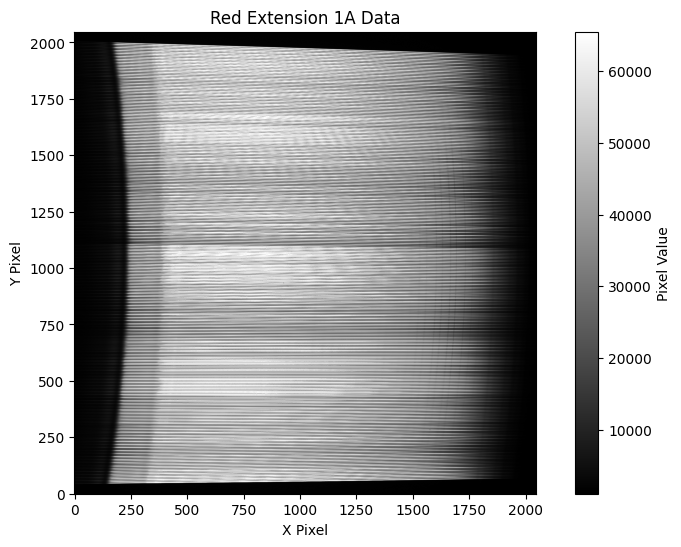

In [ ]:

plt.figure(figsize=(10, 6))
plt.imshow(hdu[3].data, cmap='gray', origin='lower')
plt.colorbar(label='Pixel Value')
plt.title('Extension Data')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()